<a href="https://colab.research.google.com/github/TottiPuc/Sandwich-Prior_superResolution/blob/main/Sandwich_deep_prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [1]:
from google.colab import drive
#drive.mount('/content/gdrive/')
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [1]:
%cd "/content/gdrive/My Drive/Colab Notebooks/deep-hs-prior-master"
%ls

/content/gdrive/My Drive/Colab Notebooks/deep-hs-prior-master
data/            LICENSE    results/              sr.mat
Dockerfile       models/    Run_Colab_deep.ipynb  utils/
environment.yml  README.md  Run_main.py


In [2]:
from __future__ import print_function
import matplotlib.pyplot as pl
from skimage.metrics import peak_signal_noise_ratio
 #os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np

import torch
import torch.optim

import scipy.io
from skimage.measure import compare_psnr
from models.downsampler import Downsampler,Spectral
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

# Load image and baselines

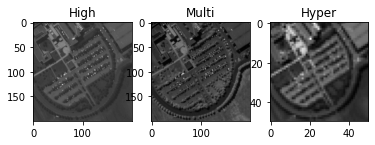

In [3]:
file_name  = 'data/sr/sr2.mat'
imgs = scipy.io.loadmat(file_name)
#plot band
band = 24

HR = imgs['HR2'].transpose(2,0,1)
HR = torch.from_numpy(HR).type(dtype)
HR = HR[None, :].cuda()

# Low resolution Image
factor = 4
KERNEL_TYPE='lanczos2'
downsampler = Downsampler(n_planes=imgs['HR2'].shape[2], factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)
img_LR_var = torch.from_numpy(downsampler(HR).detach().cpu().numpy()).type(dtype)
mostr = img_LR_var.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
plt.subplot(1,3,1),plt.imshow(imgs['HR2'][:,:,band],cmap='gray'),plt.title('High')
plt.subplot(1,3,3),plt.imshow(mostr[:, :, band],cmap='gray'),plt.title('Hyper')

dw_spectral = Spectral(Input_band=96,Oput_band=8)
img_hyper = torch.from_numpy(dw_spectral(HR).detach().cpu().numpy()).type(dtype)
mostr = img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
plt.subplot(1,3,2),plt.imshow(mostr[:, :, 5],cmap='gray'),plt.title('Multi')
plt.show()

# Set up parameters and net

In [4]:
input_depth = img_hyper.shape[1]

method =    '2D'
pad   =     'reflection'
pad2 = 'same'
OPT_OVER =  'net'

show_every = 500
save_every = 2000

LR = 0.001
tv_weight = 0.0
OPTIMIZER = 'adam'
num_iter = 12001
reg_noise_std = 0  # try 0 0.03 0.05 0.08

In [6]:
#net_input = get_noise(input_depth, method, (imgs['HR2'].shape[0], imgs['HR2'].shape[1])).type(dtype).detach()
net_input = get_noise(img_hyper.shape[1], method, (img_hyper.shape[2], img_hyper.shape[3])).type(dtype).detach()

net = skip(img_hyper.shape[1], imgs['HR2'].shape[2],
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='bilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net2 = UNet( imgs['HR2'].shape[2], imgs['HR2'].shape[2]).cuda()
# Losses
mse = torch.nn.MSELoss().type(dtype)

zero
zero
zero


# Define closure and optimize

In [10]:
def closure():
    global i, net_input

    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_BR = net2(out_HR)

    out_LR = downsampler(out_HR)
    out_spectral =  dw_spectral(out_HR)

    total_loss  = 0.50 * mse(img_LR_var, out_LR)
    total_loss += 0.50 * mse( img_hyper ,out_spectral)
    #total_loss += torch.mul(1.00, mse(img_LR_var ,out_BR ))


    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()

    # Log
    psnr_HR = peak_signal_noise_ratio(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)) 
    psnr_LR = peak_signal_noise_ratio(img_LR_var.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0))
    print('Iteration {}, PSNR_HR {:.2f},  PSNR_LR {:.2f}, total_loss {:.5f} '.format(i, psnr_HR, psnr_LR, total_loss))


    # History
    psnr_history.append([psnr_LR, psnr_HR])
    if i % show_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 15))
        ax1.imshow(imgs['HR2'][:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax2.imshow(imgs['bicubic'][:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax3.imshow(np.clip(out_HR_np, 0, 1)[:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()

    if i % save_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        scipy.io.savemat("results/result_sr_2D_it%05d.mat" % (i), {'pred': np.clip(out_HR_np, 0, 1)})

    i += 1

    return total_loss

Starting optimization with ADAM
Iteration 0, PSNR_HR 28.05,  PSNR_LR 13.58, total_loss 0.00034 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


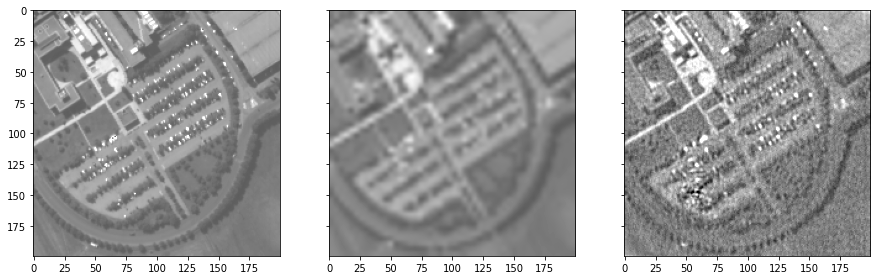

Iteration 1, PSNR_HR 23.80,  PSNR_LR 13.04, total_loss 0.00255 
Iteration 2, PSNR_HR 24.87,  PSNR_LR 13.11, total_loss 0.00195 
Iteration 3, PSNR_HR 26.42,  PSNR_LR 13.12, total_loss 0.00110 
Iteration 4, PSNR_HR 26.57,  PSNR_LR 13.13, total_loss 0.00101 
Iteration 5, PSNR_HR 25.91,  PSNR_LR 13.12, total_loss 0.00135 
Iteration 6, PSNR_HR 26.46,  PSNR_LR 13.10, total_loss 0.00108 
Iteration 7, PSNR_HR 27.42,  PSNR_LR 13.07, total_loss 0.00066 
Iteration 8, PSNR_HR 27.42,  PSNR_LR 13.04, total_loss 0.00068 
Iteration 9, PSNR_HR 27.43,  PSNR_LR 13.02, total_loss 0.00070 
Iteration 10, PSNR_HR 27.89,  PSNR_LR 13.00, total_loss 0.00055 
Iteration 11, PSNR_HR 28.11,  PSNR_LR 12.99, total_loss 0.00048 
Iteration 12, PSNR_HR 27.92,  PSNR_LR 12.98, total_loss 0.00054 
Iteration 13, PSNR_HR 27.88,  PSNR_LR 12.97, total_loss 0.00057 
Iteration 14, PSNR_HR 28.20,  PSNR_LR 12.97, total_loss 0.00047 
Iteration 15, PSNR_HR 28.58,  PSNR_LR 12.97, total_loss 0.00038 
Iteration 16, PSNR_HR 28.64,  PSNR

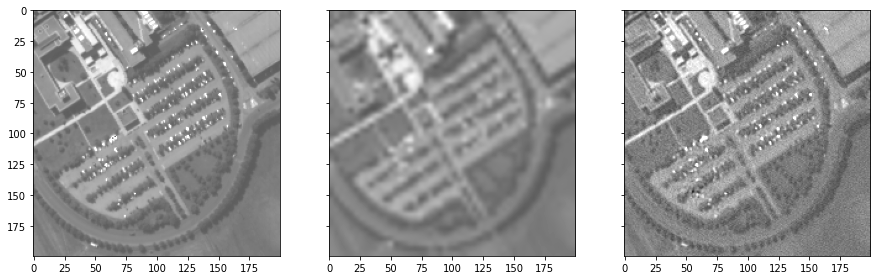

Iteration 501, PSNR_HR 32.65,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 502, PSNR_HR 32.65,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 503, PSNR_HR 32.66,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 504, PSNR_HR 32.66,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 505, PSNR_HR 32.66,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 506, PSNR_HR 32.66,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 507, PSNR_HR 32.67,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 508, PSNR_HR 32.67,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 509, PSNR_HR 32.67,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 510, PSNR_HR 32.68,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 511, PSNR_HR 32.68,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 512, PSNR_HR 32.68,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 513, PSNR_HR 32.68,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 514, PSNR_HR 32.68,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 515, PSNR_HR 32.68,  PSNR_LR 12.70, total_loss 0.00007 
Iteration 

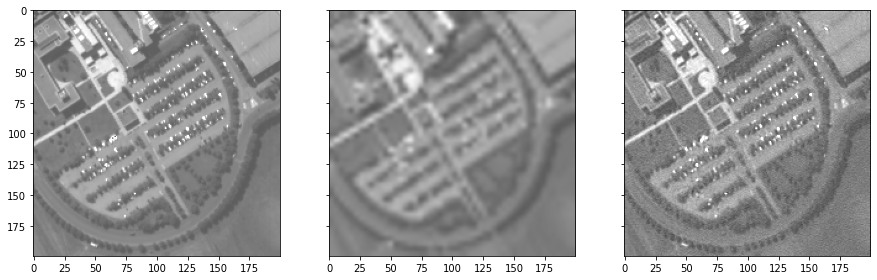

Iteration 1001, PSNR_HR 33.90,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1002, PSNR_HR 33.90,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1003, PSNR_HR 33.90,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1004, PSNR_HR 33.90,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1005, PSNR_HR 33.91,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1006, PSNR_HR 33.91,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1007, PSNR_HR 33.91,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1008, PSNR_HR 33.91,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1009, PSNR_HR 33.91,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1010, PSNR_HR 33.91,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1011, PSNR_HR 33.92,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1012, PSNR_HR 33.92,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1013, PSNR_HR 33.92,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1014, PSNR_HR 33.92,  PSNR_LR 12.70, total_loss 0.00004 
Iteration 1015, PSNR_HR 33.92,  PSNR_LR 12.70, total_loss 0.00

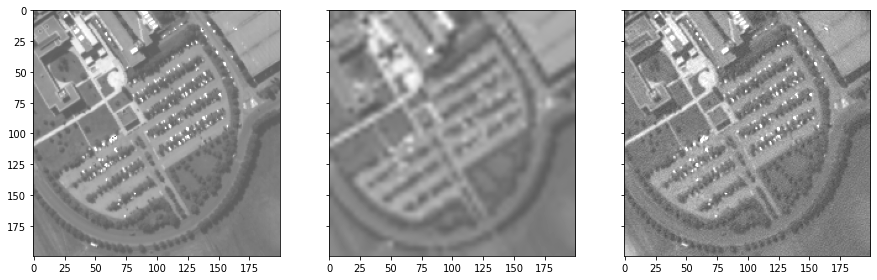

Iteration 1501, PSNR_HR 34.14,  PSNR_LR 12.71, total_loss 0.00009 
Iteration 1502, PSNR_HR 34.14,  PSNR_LR 12.71, total_loss 0.00009 
Iteration 1503, PSNR_HR 34.29,  PSNR_LR 12.71, total_loss 0.00007 
Iteration 1504, PSNR_HR 34.54,  PSNR_LR 12.70, total_loss 0.00006 
Iteration 1505, PSNR_HR 34.68,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 1506, PSNR_HR 34.70,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 1507, PSNR_HR 34.69,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 1508, PSNR_HR 34.64,  PSNR_LR 12.71, total_loss 0.00005 
Iteration 1509, PSNR_HR 34.63,  PSNR_LR 12.70, total_loss 0.00005 
Iteration 1510, PSNR_HR 34.66,  PSNR_LR 12.71, total_loss 0.00005 
Iteration 1511, PSNR_HR 34.78,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 1512, PSNR_HR 34.82,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 1513, PSNR_HR 34.77,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 1514, PSNR_HR 34.75,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 1515, PSNR_HR 34.77,  PSNR_LR 12.71, total_loss 0.00

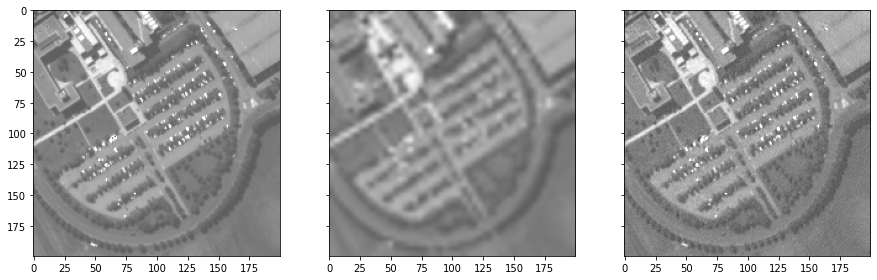

Iteration 2001, PSNR_HR 35.38,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2002, PSNR_HR 35.38,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2003, PSNR_HR 35.37,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2004, PSNR_HR 35.36,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2005, PSNR_HR 35.35,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2006, PSNR_HR 35.33,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2007, PSNR_HR 35.32,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2008, PSNR_HR 35.28,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2009, PSNR_HR 35.27,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 2010, PSNR_HR 35.24,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 2011, PSNR_HR 35.24,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 2012, PSNR_HR 35.24,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 2013, PSNR_HR 35.28,  PSNR_LR 12.71, total_loss 0.00004 
Iteration 2014, PSNR_HR 35.31,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2015, PSNR_HR 35.36,  PSNR_LR 12.71, total_loss 0.00

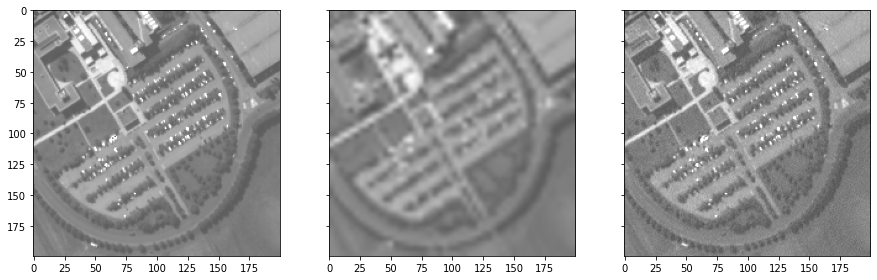

Iteration 2501, PSNR_HR 35.86,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2502, PSNR_HR 35.86,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2503, PSNR_HR 35.86,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2504, PSNR_HR 35.85,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2505, PSNR_HR 35.86,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2506, PSNR_HR 35.86,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2507, PSNR_HR 35.86,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2508, PSNR_HR 35.86,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2509, PSNR_HR 35.86,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2510, PSNR_HR 35.85,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2511, PSNR_HR 35.83,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 2512, PSNR_HR 35.81,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2513, PSNR_HR 35.77,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2514, PSNR_HR 35.72,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 2515, PSNR_HR 35.65,  PSNR_LR 12.71, total_loss 0.00

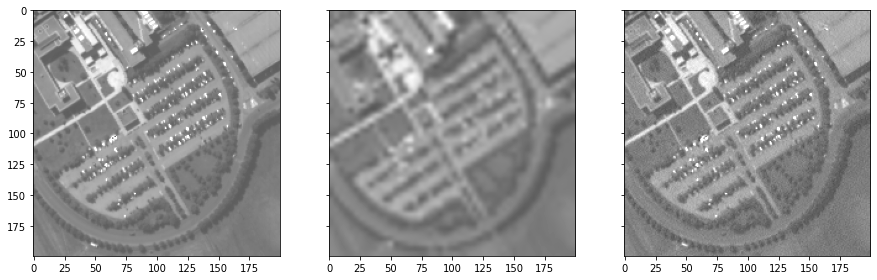

Iteration 3001, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3002, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3003, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3004, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3005, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3006, PSNR_HR 36.27,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3007, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3008, PSNR_HR 36.27,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3009, PSNR_HR 36.27,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3010, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3011, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3012, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3013, PSNR_HR 36.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3014, PSNR_HR 36.25,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3015, PSNR_HR 36.24,  PSNR_LR 12.71, total_loss 0.00

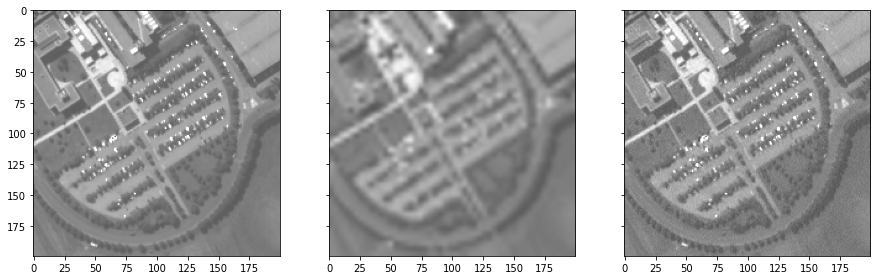

Iteration 3501, PSNR_HR 36.58,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3502, PSNR_HR 36.57,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3503, PSNR_HR 36.57,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3504, PSNR_HR 36.56,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3505, PSNR_HR 36.55,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3506, PSNR_HR 36.53,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3507, PSNR_HR 36.51,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3508, PSNR_HR 36.48,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3509, PSNR_HR 36.47,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3510, PSNR_HR 36.45,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3511, PSNR_HR 36.45,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3512, PSNR_HR 36.45,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3513, PSNR_HR 36.47,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3514, PSNR_HR 36.45,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 3515, PSNR_HR 36.42,  PSNR_LR 12.71, total_loss 0.00

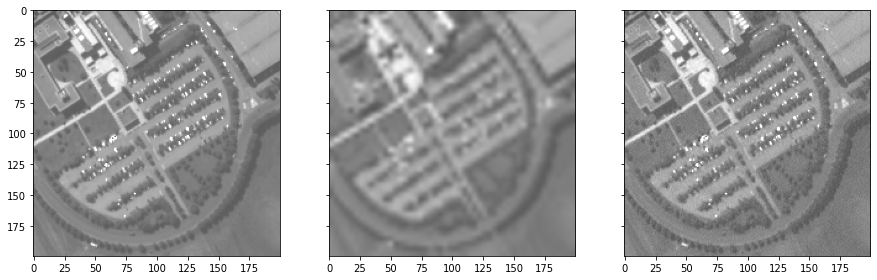

Iteration 4001, PSNR_HR 36.73,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4002, PSNR_HR 36.72,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4003, PSNR_HR 36.73,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4004, PSNR_HR 36.70,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4005, PSNR_HR 36.70,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4006, PSNR_HR 36.68,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4007, PSNR_HR 36.68,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4008, PSNR_HR 36.66,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4009, PSNR_HR 36.67,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4010, PSNR_HR 36.68,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4011, PSNR_HR 36.70,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4012, PSNR_HR 36.72,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4013, PSNR_HR 36.76,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4014, PSNR_HR 36.80,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4015, PSNR_HR 36.84,  PSNR_LR 12.71, total_loss 0.00

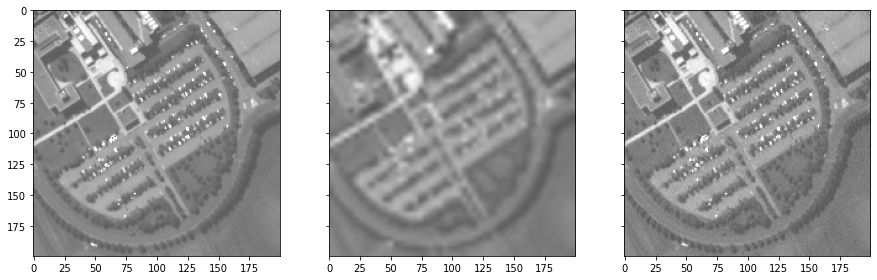

Iteration 4501, PSNR_HR 36.96,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4502, PSNR_HR 36.91,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4503, PSNR_HR 36.86,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4504, PSNR_HR 36.82,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4505, PSNR_HR 36.79,  PSNR_LR 12.72, total_loss 0.00003 
Iteration 4506, PSNR_HR 36.79,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 4507, PSNR_HR 36.82,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4508, PSNR_HR 36.87,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4509, PSNR_HR 36.92,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4510, PSNR_HR 36.97,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4511, PSNR_HR 37.01,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4512, PSNR_HR 37.03,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4513, PSNR_HR 37.04,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 4514, PSNR_HR 37.02,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 4515, PSNR_HR 36.99,  PSNR_LR 12.72, total_loss 0.00

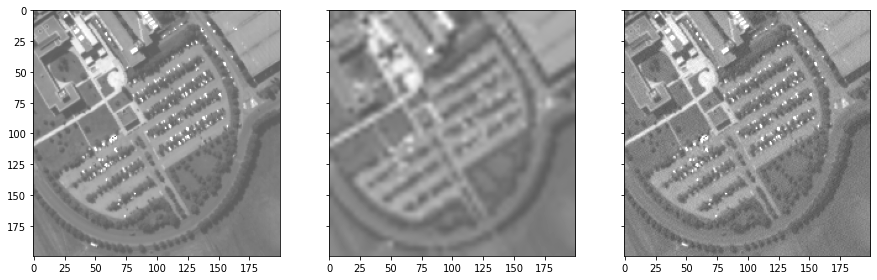

Iteration 5001, PSNR_HR 37.28,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 5002, PSNR_HR 37.27,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 5003, PSNR_HR 37.25,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 5004, PSNR_HR 37.22,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 5005, PSNR_HR 37.18,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 5006, PSNR_HR 37.12,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 5007, PSNR_HR 37.07,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 5008, PSNR_HR 37.07,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 5009, PSNR_HR 37.13,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 5010, PSNR_HR 37.21,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 5011, PSNR_HR 37.23,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 5012, PSNR_HR 37.19,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 5013, PSNR_HR 37.18,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 5014, PSNR_HR 37.21,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 5015, PSNR_HR 37.23,  PSNR_LR 12.72, total_loss 0.00

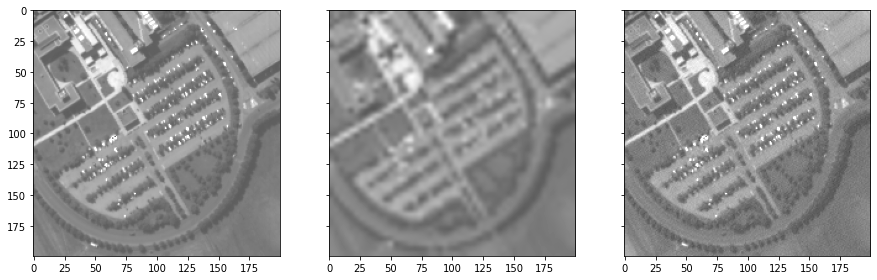

Iteration 5501, PSNR_HR 37.10,  PSNR_LR 12.71, total_loss 0.00003 
Iteration 5502, PSNR_HR 37.15,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 5503, PSNR_HR 37.26,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 5504, PSNR_HR 37.35,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 5505, PSNR_HR 37.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 5506, PSNR_HR 37.36,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 5507, PSNR_HR 37.33,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 5508, PSNR_HR 37.34,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 5509, PSNR_HR 37.38,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 5510, PSNR_HR 37.41,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 5511, PSNR_HR 37.43,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 5512, PSNR_HR 37.44,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 5513, PSNR_HR 37.44,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 5514, PSNR_HR 37.43,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 5515, PSNR_HR 37.43,  PSNR_LR 12.72, total_loss 0.00

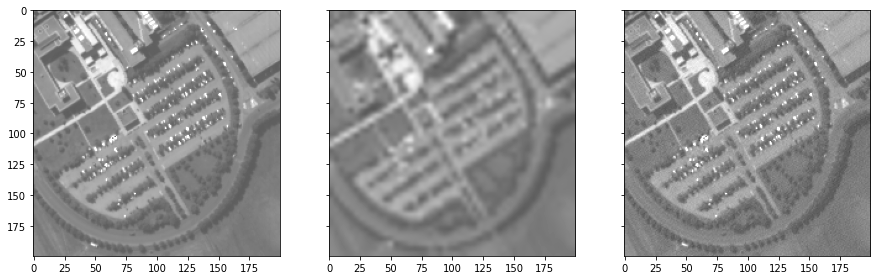

Iteration 6001, PSNR_HR 37.62,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 6002, PSNR_HR 37.62,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6003, PSNR_HR 37.60,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 6004, PSNR_HR 37.60,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6005, PSNR_HR 37.57,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6006, PSNR_HR 37.56,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 6007, PSNR_HR 37.53,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6008, PSNR_HR 37.51,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6009, PSNR_HR 37.49,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6010, PSNR_HR 37.48,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6011, PSNR_HR 37.47,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6012, PSNR_HR 37.48,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6013, PSNR_HR 37.48,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 6014, PSNR_HR 37.48,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6015, PSNR_HR 37.47,  PSNR_LR 12.72, total_loss 0.00

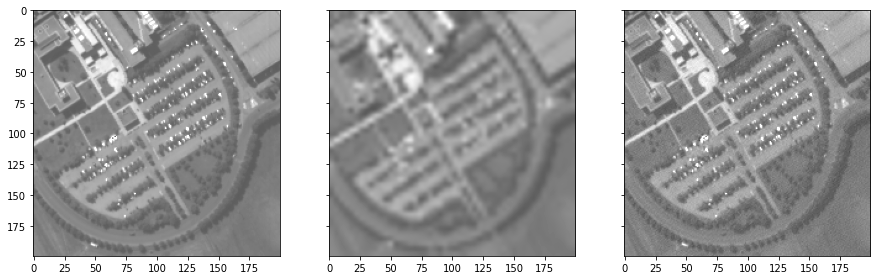

Iteration 6501, PSNR_HR 37.65,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 6502, PSNR_HR 37.61,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 6503, PSNR_HR 37.58,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6504, PSNR_HR 37.54,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 6505, PSNR_HR 37.53,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6506, PSNR_HR 37.54,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 6507, PSNR_HR 37.61,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 6508, PSNR_HR 37.69,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6509, PSNR_HR 37.77,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 6510, PSNR_HR 37.78,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6511, PSNR_HR 37.74,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6512, PSNR_HR 37.70,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6513, PSNR_HR 37.71,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6514, PSNR_HR 37.74,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 6515, PSNR_HR 37.77,  PSNR_LR 12.71, total_loss 0.00

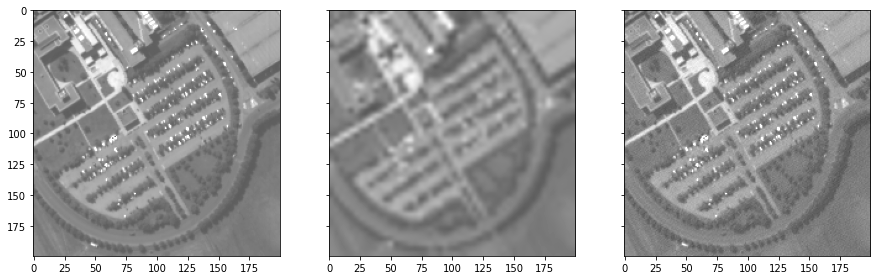

Iteration 7001, PSNR_HR 37.93,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 7002, PSNR_HR 37.92,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7003, PSNR_HR 37.89,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 7004, PSNR_HR 37.85,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7005, PSNR_HR 37.80,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 7006, PSNR_HR 37.73,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 7007, PSNR_HR 37.68,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 7008, PSNR_HR 37.63,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 7009, PSNR_HR 37.63,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 7010, PSNR_HR 37.64,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 7011, PSNR_HR 37.64,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 7012, PSNR_HR 37.64,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 7013, PSNR_HR 37.64,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 7014, PSNR_HR 37.68,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 7015, PSNR_HR 37.71,  PSNR_LR 12.72, total_loss 0.00

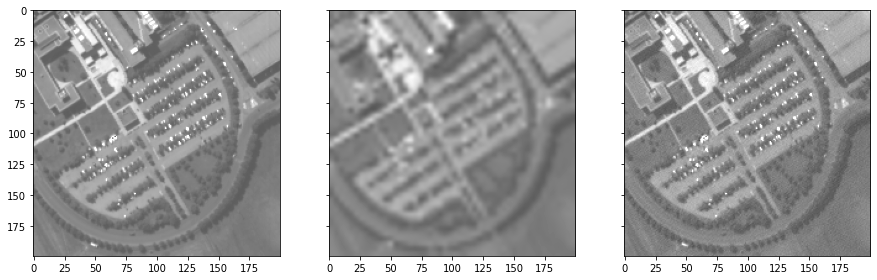

Iteration 7501, PSNR_HR 37.96,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7502, PSNR_HR 37.98,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7503, PSNR_HR 38.02,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 7504, PSNR_HR 38.04,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7505, PSNR_HR 38.05,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7506, PSNR_HR 38.03,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7507, PSNR_HR 38.03,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7508, PSNR_HR 38.05,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 7509, PSNR_HR 38.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7510, PSNR_HR 38.09,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7511, PSNR_HR 38.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7512, PSNR_HR 38.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7513, PSNR_HR 38.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7514, PSNR_HR 38.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 7515, PSNR_HR 38.08,  PSNR_LR 12.72, total_loss 0.00

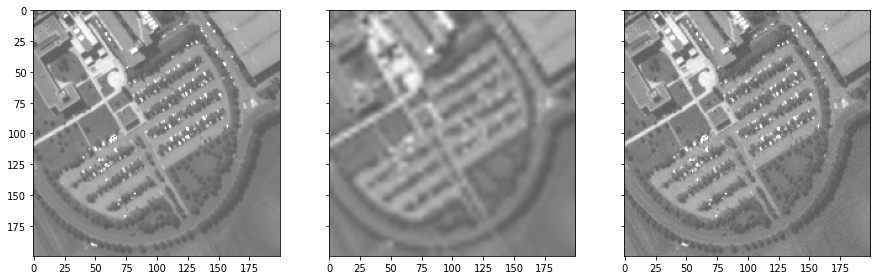

Iteration 8001, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8002, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8003, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8004, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8005, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8006, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8007, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8008, PSNR_HR 38.24,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8009, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8010, PSNR_HR 38.23,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8011, PSNR_HR 38.24,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8012, PSNR_HR 38.24,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8013, PSNR_HR 38.24,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8014, PSNR_HR 38.24,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8015, PSNR_HR 38.24,  PSNR_LR 12.72, total_loss 0.00

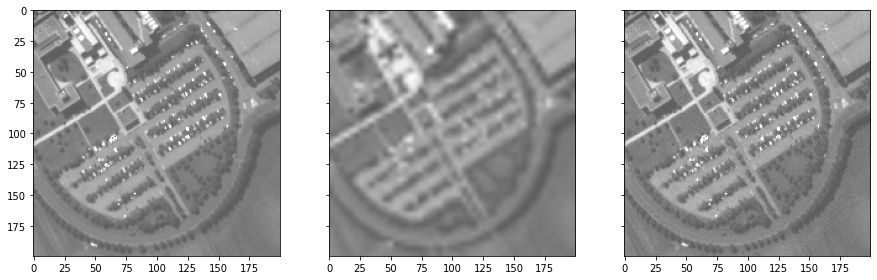

Iteration 8501, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8502, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8503, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8504, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8505, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8506, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8507, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8508, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8509, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8510, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8511, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8512, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8513, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8514, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 8515, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00

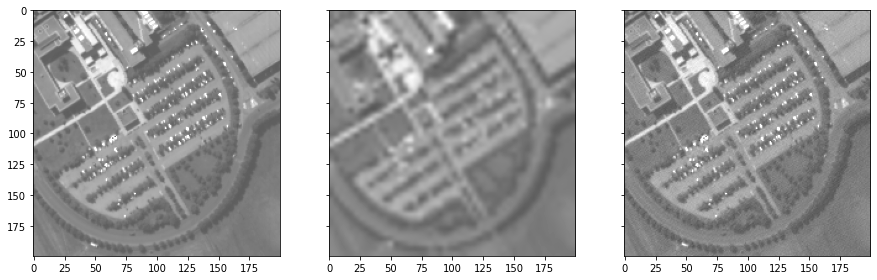

Iteration 9001, PSNR_HR 38.49,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9002, PSNR_HR 38.50,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9003, PSNR_HR 38.50,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9004, PSNR_HR 38.51,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9005, PSNR_HR 38.51,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9006, PSNR_HR 38.51,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9007, PSNR_HR 38.51,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9008, PSNR_HR 38.51,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9009, PSNR_HR 38.51,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9010, PSNR_HR 38.51,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9011, PSNR_HR 38.52,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9012, PSNR_HR 38.52,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9013, PSNR_HR 38.52,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9014, PSNR_HR 38.52,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9015, PSNR_HR 38.52,  PSNR_LR 12.72, total_loss 0.00

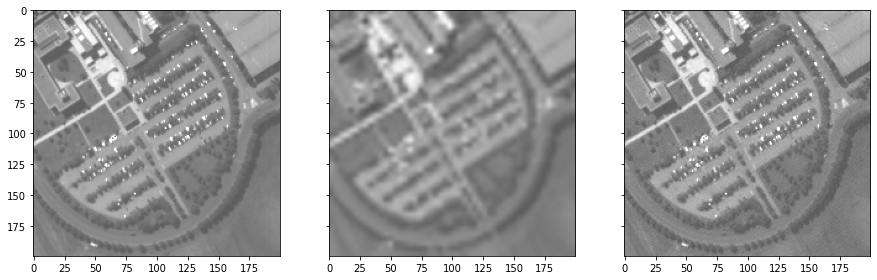

Iteration 9501, PSNR_HR 38.61,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9502, PSNR_HR 38.59,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9503, PSNR_HR 38.57,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9504, PSNR_HR 38.53,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9505, PSNR_HR 38.49,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9506, PSNR_HR 38.42,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9507, PSNR_HR 38.34,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 9508, PSNR_HR 38.24,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 9509, PSNR_HR 38.18,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 9510, PSNR_HR 38.14,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 9511, PSNR_HR 38.19,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 9512, PSNR_HR 38.28,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 9513, PSNR_HR 38.39,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9514, PSNR_HR 38.45,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 9515, PSNR_HR 38.48,  PSNR_LR 12.72, total_loss 0.00

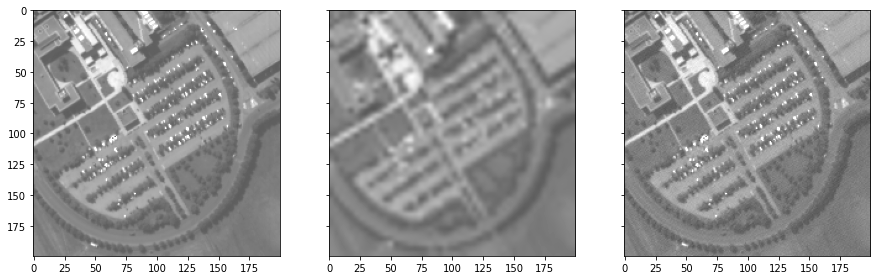

Iteration 10001, PSNR_HR 38.77,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10002, PSNR_HR 38.76,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10003, PSNR_HR 38.76,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10004, PSNR_HR 38.75,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10005, PSNR_HR 38.74,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10006, PSNR_HR 38.71,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10007, PSNR_HR 38.70,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 10008, PSNR_HR 38.65,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10009, PSNR_HR 38.61,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 10010, PSNR_HR 38.52,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10011, PSNR_HR 38.46,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 10012, PSNR_HR 38.35,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 10013, PSNR_HR 38.31,  PSNR_LR 12.71, total_loss 0.00002 
Iteration 10014, PSNR_HR 38.27,  PSNR_LR 12.72, total_loss 0.00002 
Iteration 10015, PSNR_HR 38.33,  PSNR_LR 12.71, 

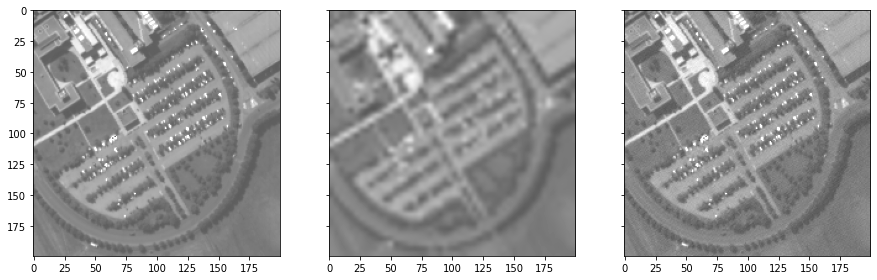

Iteration 10501, PSNR_HR 38.88,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10502, PSNR_HR 38.89,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10503, PSNR_HR 38.89,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10504, PSNR_HR 38.89,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10505, PSNR_HR 38.89,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10506, PSNR_HR 38.89,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10507, PSNR_HR 38.89,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10508, PSNR_HR 38.89,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10509, PSNR_HR 38.89,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10510, PSNR_HR 38.88,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10511, PSNR_HR 38.88,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10512, PSNR_HR 38.88,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10513, PSNR_HR 38.88,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10514, PSNR_HR 38.87,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 10515, PSNR_HR 38.86,  PSNR_LR 12.72, 

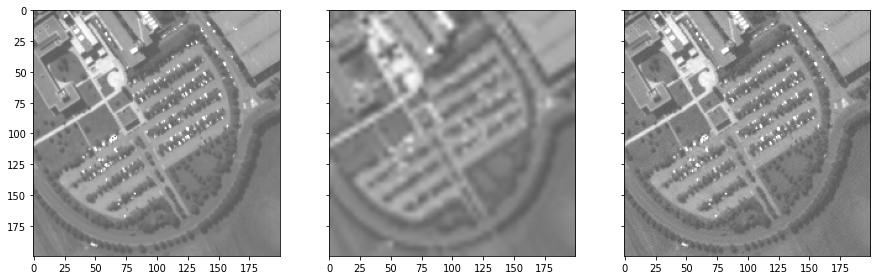

Iteration 11001, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11002, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11003, PSNR_HR 39.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11004, PSNR_HR 39.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11005, PSNR_HR 39.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11006, PSNR_HR 39.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11007, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11008, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11009, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11010, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11011, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11012, PSNR_HR 39.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11013, PSNR_HR 39.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11014, PSNR_HR 39.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11015, PSNR_HR 39.08,  PSNR_LR 12.72, 

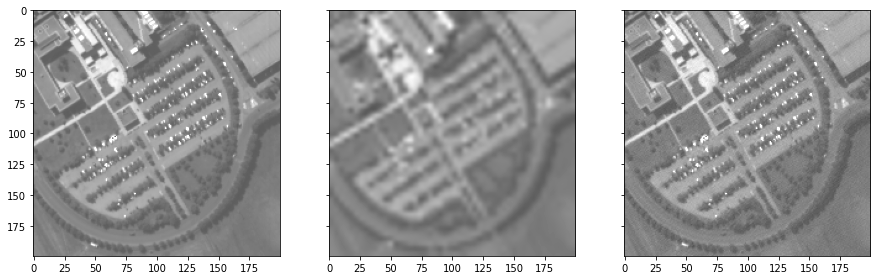

Iteration 11501, PSNR_HR 39.01,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 11502, PSNR_HR 38.99,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11503, PSNR_HR 39.01,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 11504, PSNR_HR 39.04,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11505, PSNR_HR 39.04,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11506, PSNR_HR 39.05,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11507, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11508, PSNR_HR 39.10,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11509, PSNR_HR 39.10,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11510, PSNR_HR 39.09,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11511, PSNR_HR 39.07,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11512, PSNR_HR 39.08,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11513, PSNR_HR 39.09,  PSNR_LR 12.72, total_loss 0.00001 
Iteration 11514, PSNR_HR 39.10,  PSNR_LR 12.71, total_loss 0.00001 
Iteration 11515, PSNR_HR 39.08,  PSNR_LR 12.72, 

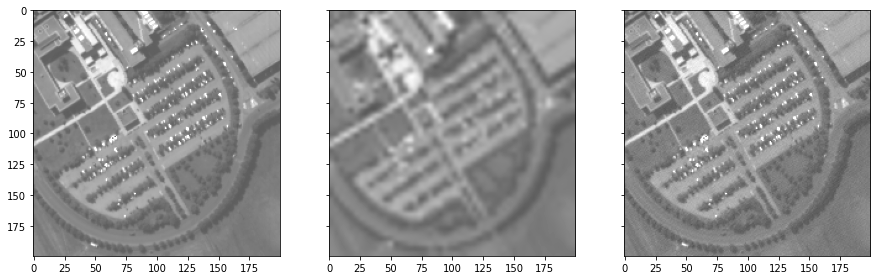

In [11]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [9]:
#funcional
def closure():
    global i, net_input

    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_BR = net2(out_HR)

    out_LR = downsampler(out_HR)
    out_spectral =  dw_spectral(out_HR)

    total_loss  = 0.50 * mse(img_LR_var, out_LR)
    total_loss += 0.50 * mse( img_hyper ,out_spectral)
    #total_loss = torch.mul(1.00, mse(img_LR_var ,out_BR ))


    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()

    # Log
    psnr_HR = peak_signal_noise_ratio(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)) 
    psnr_LR = peak_signal_noise_ratio(img_LR_var.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_LR.detach().cpu().squeeze().numpy().transpose(1, 2, 0))
    print('Iteration {}, PSNR_HR {:.2f},  PSNR_LR {:.2f}, total_loss {:.5f} '.format(i, psnr_HR, psnr_LR, total_loss))


    # History
    psnr_history.append([psnr_LR, psnr_HR])
    if i % show_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 15))
        ax1.imshow(imgs['HR2'][:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax2.imshow(imgs['bicubic'][:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax3.imshow(np.clip(out_HR_np, 0, 1)[:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()

    if i % save_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        scipy.io.savemat("results/result_sr_2D_it%05d.mat" % (i), {'pred': np.clip(out_HR_np, 0, 1)})

    i += 1

    return total_loss